<a href="https://colab.research.google.com/github/Ruphai/UBS/blob/main/Logistic_Regression_RufaiBalogun.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Logistic Regression by using the gradient descent algorithm**

## Workspace utilities
Load required packages and worskpace tools

In [ ]:
import os # working directory
import pandas as pd # data analysis
from scipy import stats # descriptive statistics
import matplotlib.pyplot as plt # graphics
import numpy as np # maths
import sklearn.preprocessing # data standardisation
from collections import Counter # table frequency

from sklearn import datasets # data
from sklearn.linear_model import LogisticRegression    # Logistic Regression
from sklearn.model_selection import train_test_split # train and test samples
from sklearn.metrics import confusion_matrix # confusion matrix
from scipy import optimize # optimisation algorithms

## Data
The data relates to a breast cancer clinical study conducted at the University of Winconsin. This is to predict the status of the tumor (malignant=1 or benign=0) from characteristics of cells taken from patients
* radius (mean of distances from center to points on the perimeter)
* texture (standard deviation of gray-scale values)
* perimeter
* area
* ···

The data was originally published by W.N. Street, W.H. Wolberg and O.L. Mangasarian. Nuclear feature extraction for breast tumor diagnosis. IS&T/SPIE 1993 International Symposium on Electronic Imaging : Science and Technology, volume 1905, pages 861-870, San Jose, CA, 1993.

**Objective:** To study the probability of having a malignant tumor depending on certain characteristics.

The practical lab includes the following steps (you must fill in the different notebook cells):

* Import data
* Build the necessary functions: f, cost, gradient then implement the gradient descent algorithm (some functions are identical to those produced in the case of the linear regression)
* Test for the case of simple logistic regression
* Then extend the test to multiple logistic regression
* Return the model coefficients and the values of the cost function for all iterations
* Vary the parameters of the algorithm (initialization, learning rate) and comment.
* Compare with native Python optimization solutions (no exact solution here)

In [ ]:
#-- Data import
breast_cancer = datasets.load_breast_cancer()
print(breast_cancer.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

In [ ]:
#-- Obtain our dataset from sklearn datasets
data=breast_cancer.data
Y=breast_cancer.target
names = breast_cancer.feature_names
df=pd.DataFrame(data)
df.columns=names

In [ ]:
# a quick view of data structure
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
# Show some statistical description with Counter
print('\t', Counter(Y)) # nb of cases / controls
df.groupby(Y).mean()

	 Counter({1: 357, 0: 212})


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.462830,21.604906,115.365377,978.376415,0.102898,0.145188,0.160775,0.087990,0.192909,0.062680,0.609083,1.210915,4.323929,72.672406,0.006780,0.032281,0.041824,0.015060,0.020472,0.004062,21.134811,29.318208,141.370330,1422.286321,0.144845,0.374824,0.450606,0.182237,0.323468,0.091530
1,12.146524,17.914762,78.075406,462.790196,0.092478,0.080085,0.046058,0.025717,0.174186,0.062867,0.284082,1.220380,2.000321,21.135148,0.007196,0.021438,0.025997,0.009858,0.020584,0.003636,13.379801,23.515070,87.005938,558.899440,0.124959,0.182673,0.166238,0.074444,0.270246,0.079442


In [ ]:
# Check the correlation between features and target
df.insert(loc=0, column='class', value=Y) # temporarily assign target variable to the feature set to check relationship with other features
corr = df.corr().round(2)
corr.style.background_gradient(cmap='bwr_r')

,class,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
class,1.000000,-0.730000,-0.420000,-0.740000,-0.710000,-0.360000,-0.600000,-0.700000,-0.780000,-0.330000,0.010000,-0.570000,0.010000,-0.560000,-0.550000,0.070000,-0.290000,-0.250000,-0.410000,0.010000,-0.080000,-0.780000,-0.460000,-0.780000,-0.730000,-0.420000,-0.590000,-0.660000,-0.790000,-0.420000,-0.320000
mean radius,-0.730000,1.000000,0.320000,1.000000,0.990000,0.170000,0.510000,0.680000,0.820000,0.150000,-0.310000,0.680000,-0.100000,0.670000,0.740000,-0.220000,0.210000,0.190000,0.380000,-0.100000,-0.040000,0.970000,0.300000,0.970000,0.940000,0.120000,0.410000,0.530000,0.740000,0.160000,0.010000
mean texture,-0.420000,0.320000,1.000000,0.330000,0.320000,-0.020000,0.240000,0.300000,0.290000,0.070000,-0.080000,0.280000,0.390000,0.280000,0.260000,0.010000,0.190000,0.140000,0.160000,0.010000,0.050000,0.350000,0.910000,0.360000,0.340000,0.080000,0.280000,0.300000,0.300000,0.110000,0.120000
mean perimeter,-0.740000,1.000000,0.330000,1.000000,0.990000,0.210000,0.560000,0.720000,0.850000,0.180000,-0.260000,0.690000,-0.090000,0.690000,0.740000,-0.200000,0.250000,0.230000,0.410000,-0.080000,-0.010000,0.970000,0.300000,0.970000,0.940000,0.150000,0.460000,0.560000,0.770000,0.190000,0.050000
mean area,-0.710000,0.990000,0.320000,0.990000,1.000000,0.180000,0.500000,0.690000,0.820000,0.150000,-0.280000,0.730000,-0.070000,0.730000,0.800000,-0.170000,0.210000,0.210000,0.370000,-0.070000,-0.020000,0.960000,0.290000,0.960000,0.960000,0.120000,0.390000,0.510000,0.720000,0.140000,0.000000
mean smoothness,-0.360000,0.170000,-0.020000,0.210000,0.180000,1.000000,0.660000,0.520000,0.550000,0.560000,0.580000,0.300000,0.070000,0.300000,0.250000,0.330000,0.320000,0.250000,0.380000,0.200000,0.280000,0.210000,0.040000,0.240000,0.210000,0.810000,0.470000,0.430000,0.500000,0.390000,0.500000
mean compactness,-0.600000,0.510000,0.240000,0.560000,0.500000,0.660000,1.000000,0.880000,0.830000,0.600000,0.570000,0.500000,0.050000,0.550000,0.460000,0.140000,0.740000,0.570000,0.640000,0.230000,0.510000,0.540000,0.250000,0.590000,0.510000,0.570000,0.870000,0.820000,0.820000,0.510000,0.690000
mean concavity,-0.700000,0.680000,0.300000,0.720000,0.690000,0.520000,0.880000,1.000000,0.920000,0.500000,0.340000,0.630000,0.080000,0.660000,0.620000,0.100000,0.670000,0.690000,0.680000,0.180000,0.450000,0.690000,0.300000,0.730000,0.680000,0.450000,0.750000,0.880000,0.860000,0.410000,0.510000
mean concave points,-0.780000,0.820000,0.290000,0.850000,0.820000,0.550000,0.830000,0.920000,1.000000,0.460000,0.170000,0.700000,0.020000,0.710000,0.690000,0.030000,0.490000,0.440000,0.620000,0.100000,0.260000,0.830000,0.290000,0.860000,0.810000,0.450000,0.670000,0.750000,0.910000,0.380000,0.370000
mean symmetry,-0.330000,0.150000,0.070000,0.180000,0.150000,0.560000,0.600000,0.500000,0.460000,1.000000,0.480000,0.300000,0.130000,0.310000,0.220000,0.190000,0.420000,0.340000,0.390000,0.450000,0.330000,0.190000,0.090000,0.220000,0.180000,0.430000,0.470000,0.430000,0.430000,0.700000,0.440000


In [ ]:
df.drop('class', axis=1) #remove the target variable from the feature sets

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


#### Parameter Selection

"""
In this case, where we are provided with a set of parameters, fitting our to-be-developed 
model on the whole feature could potentially lead to overfitting, unnecessary complexity 
and model capturing the redundancy in the data. 
In order to bulwark this, we take as part of our data preparation, a model feature step to 
select the best parameters that represents the patterns in our data features and targets. 
While there are many methods that have been developed for performing this operation, here, 
we select the parameters with the highest negative correlation as our model features. 
The threshold for this correlation is taken to be values with negative correlation above 
0.70 indicating strong negative correlation with our target class.
In this case, the following parameters were selected: mean_radius, mean_perimeter, mean area, mean concave points, worst radius, worst perimeter, 
worst area, worst concave points(highest negative correlation)
"""

In [ ]:
df.columns #examine the names of columns to select from

Index(['class', 'mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='object')

In [ ]:
#-- Build Xs and Xm for simple and multiple logistic regression
Xs = np.vstack((df.loc[:, ['worst concave points']].to_numpy()))
Xm = np.vstack((df.loc[:, ['mean radius', 'mean perimeter', 'mean area', 'mean concave points', 'worst radius', 'worst perimeter', 'worst area', 'worst concave points']].to_numpy()))

In [ ]:
print("The shape of X matrix for simple linear regression is: ", Xs.shape, 
      "\nThe shape of X matrix for multiple linear regression is: ", Xm.shape)

The shape of X matrix for simple linear regression is:  (569, 1) 
The shape of X matrix for multiple linear regression is:  (569, 8)


## Logistic regression by using the gradient descent algorithm


#### Data standardisation

In [ ]:
###### -- X standardisation
### Here, we use a mean-centering normalisation to  standardize our datasets to reduce the influence of noisy data.

def standardisation(x):
  return ((x - np.nanmean(x, axis = 0))/np.nanstd(x, axis = 0))

#Test 1: Simple Regression
Xs_std = standardisation(Xs)
print('Standardized X matrix for linear regression: \n', Xs_std)
#Test 2: Multiple Regression
Xm_std = standardisation(Xm)
print('Standardized X matrix for multiple regression: \n', Xm_std)

Standardized X matrix for linear regression: 
 [[ 2.29607613e+00]
 [ 1.08708430e+00]
 [ 1.95500035e+00]
 [ 2.17578601e+00]
 [ 7.29259257e-01]
 [ 9.05887786e-01]
 [ 1.19671580e+00]
 [ 6.24195735e-01]
 [ 1.39161624e+00]
 [ 1.62001520e+00]
 [-2.26209729e-01]
 [ 1.01095131e+00]
 [ 9.45476939e-01]
 [-4.12065711e-02]
 [ 1.61696988e+00]
 [ 8.61730654e-01]
 [ 7.04896701e-01]
 [ 1.41141082e+00]
 [ 1.89104864e+00]
 [ 2.16122925e-01]
 [-6.36109731e-01]
 [-7.96902599e-01]
 [ 1.89866194e+00]
 [ 1.31396060e+00]
 [ 1.44490933e+00]
 [ 2.13771951e+00]
 [ 2.36764114e+00]
 [ 5.23700192e-01]
 [ 1.33680049e+00]
 [ 4.71929761e-01]
 [ 1.06881238e+00]
 [ 6.08969137e-01]
 [ 1.06728972e+00]
 [ 9.72884815e-01]
 [ 1.09317493e+00]
 [ 1.01551929e+00]
 [ 4.58225823e-01]
 [-9.81753492e-01]
 [-1.30364376e+00]
 [ 1.69310287e+00]
 [-5.18651892e-02]
 [ 4.23204649e-01]
 [ 2.05092791e+00]
 [ 5.26745511e-01]
 [ 7.01851381e-01]
 [ 1.87582204e+00]
 [-1.35465286e+00]
 [ 1.43425072e+00]
 [-7.48025222e-01]
 [ 2.06986966e-01]
 [-

In [ ]:
#-- Preparing the matrix used for the regression linear when using the gradient descent algorithm add 1 vector column
ones = np.ones((len(df['mean radius']), 1))
Xs = np.hstack((ones, Xs_std))
Xm = np.hstack((ones, Xm_std))

In [ ]:
# Standardized X for Simple Logistic Regression
Xs

array([[ 1.        ,  2.29607613],
       [ 1.        ,  1.0870843 ],
       [ 1.        ,  1.95500035],
       ...,
       [ 1.        ,  0.41406869],
       [ 1.        ,  2.28998549],
       [ 1.        , -1.74506282]])

In [ ]:
# Standardized X for Multiple Logistic Regression
Xm

array([[ 1.        ,  1.09706398,  1.26993369, ...,  2.30360062,
         2.00123749,  2.29607613],
       [ 1.        ,  1.82982061,  1.68595471, ...,  1.53512599,
         1.89048899,  1.0870843 ],
       [ 1.        ,  1.57988811,  1.56650313, ...,  1.34747521,
         1.45628455,  1.95500035],
       ...,
       [ 1.        ,  0.70228425,  0.67267578, ...,  0.57900058,
         0.42790561,  0.41406869],
       [ 1.        ,  1.83834103,  1.98252415, ...,  2.30360062,
         1.65317077,  2.28998549],
       [ 1.        , -1.80840125, -1.81438851, ..., -1.43273495,
        -1.07581292, -1.74506282]])

#### Logistic Function

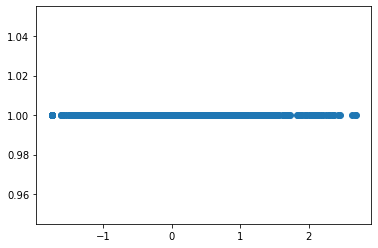

In [ ]:
#-- Model
# be careful: X contains X_0 = [1,...,1] + X_j

Bs = np.random.rand(Xs.shape[1]).reshape(Xs.shape[1], 1)
Bm = np.random.rand(Xm.shape[1]).reshape(Xm.shape[1], 1)

# logit function
def logit(x, beta):
  return np.dot(x, beta)

# sigmoid function
def sigmoid(x):
   return (1/(1+ np.exp(-x)))

def probability(x, beta):
  return sigmoid(logit(x, beta))
#-- Test 1 - simple regression

plt.scatter(Xs[:, 1], np.round(probability(Xs, Bs)))
#print('Simple  Logistic Regression \n', probability(Xs, Bs))

#-- Test 2 - multiple regression
#print('\n Multiple Logistic Regression \n', probability(Xm, Bm))
#plt.scatter(Xm[:, 1], probability(Xm, Bm))

#### Cost Function

In [ ]:
#-- Cost function
'''
The Logistic regression cost is estimated by the Log-likelihood function. 
The aim of our modelling is to maximise the Log-likelihood at each iteration to 
get the best weight for our model
'''
def cost(x, y, beta):
  m = x.shape[0]
  f = probability(x, beta)
  return -(1/m)* np.sum(y*np.log(f) + (1-y)*np.log(1-f))

#Test 1: Simple regression
Y = Y.reshape(Y.shape[0], 1)
cost_simple = cost(Xs, Y, Bs)
print("Estimated cost for simple logistic regression: \n", cost_simple)

#Test 2:Multiple regression
cost_multiple = cost(Xm, Y, Bm)
print('\n')
print("Estimated cost for multiple logistic regression: \n", cost_multiple)


Estimated cost for simple logistic regression: 
 0.6917960594669462


Estimated cost for multiple logistic regression: 
 3.1289204458553246


#### Gradient

In [ ]:
#Gradient

def grad(x, y, beta):
  m = x.shape[0]
  f = probability(x, beta)
  return (1/m)*(np.dot(x.T, (f - y)))

#-- Test 1 - simple regression
Gs = grad(Xs, Y, Bs)
print("Gradient of Simple Logistic Regression: \n", Gs)

#-- Test 2 - multiple regression
Gm = grad(Xm, Y, Bm)
print('\n')
print("Gradient of Multiple Logistic Regression: \n", Gm)

Gradient of Simple Logistic Regression: 
 [[-0.00678306]
 [ 0.40237262]]


Gradient of Multiple Logistic Regression: 
 [[-0.1325576 ]
 [ 0.68063005]
 [ 0.69094398]
 [ 0.6516542 ]
 [ 0.70251599]
 [ 0.70731902]
 [ 0.71363216]
 [ 0.66026748]
 [ 0.72186229]]


#### Gradient Descent Algorithm

In [ ]:
def grad_descent(x, y, beta, alpha, no_of_iter, tolerance = 0.0000001):
    #size of observations
    size = x.shape[1]

    #list to store the beta values and cost values
    parameters = np.zeros([no_of_iter, size])

    costs_val=[]
    
    #calculate the beta values for each iteration

    for i in range(no_of_iter):
      beta = beta - alpha*grad(x, y, beta)

      parameters[i, :]=beta.reshape(size)

      costs= cost(x, y, beta)
      
      if len(costs_val)>=2 and costs_val[-1]-costs<tolerance:
        break
      costs_val.append(costs)

    return parameters, costs_val

### Test gradient descent algorithm



#### Gradient computation for simple logistic regression

Text(0.5, 1.0, 'Cost vs Iterations Analysis::Simple Logistic Regression')

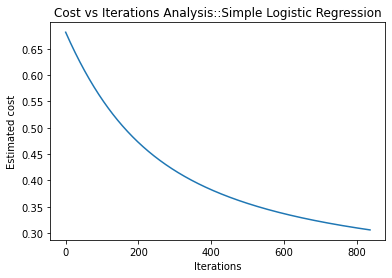

In [ ]:
# Test for simple Logistic Regression

beta = np.random.rand(Xs.shape[1]).reshape(Xs.shape[1], 1)
alpha = 0.01   #Learning Rate
no_iter = 10000  #number of iteration tested on

#beta = np.random.randn(beta_shape, 1) #initializing random values

parameters, cost_values = grad_descent(Xs, Y, beta, alpha, no_iter, 0.0001)

optimal_params=parameters[len(cost_values)-1]

# Plotting Line Plot for Number of Iterations vs MSE
plt.plot(range(len(cost_values)),cost_values)
plt.xlabel('Iterations')
plt.ylabel('Estimated cost')
plt.title('Cost vs Iterations Analysis::Simple Logistic Regression')


In [ ]:
y_pred = probability(Xs, optimal_params)
score = float(sum(np.rint(y_pred) == Y[:, 0]))/ float(len(Y))
print(score)

0.9173989455184535


In [ ]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
cm = confusion_matrix(Y, np.rint(y_pred))
clf =  np.rint(probability(Xs, optimal_params))
#plot_confusion_matrix(np.rint(clf), Xs, Y)
#plot_confusion_matrix(clf, Xs, Y)
#plt.show()
cm

array([[176,  36],
       [ 11, 346]])

#### Gradient computation for multiple logistic regression

Text(0.5, 1.0, 'Cost vs Iterations Analysis')

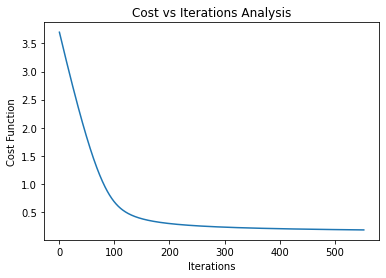

In [ ]:
# Test for multiple Logistic regression
beta_mult = np.random.rand(Xm.shape[1]).reshape(Xm.shape[1], 1)
alpha = 0.01   #Learning Rate
no_iter = 10000  #number of iteration tested on

#beta = np.random.randn(beta_shape, 1) #initializing random values

parameters, cost_values = grad_descent(Xm, Y, beta_mult, alpha, no_iter, 0.0001)

optimal_params_m=parameters[len(cost_values)-1]

# Plotting Line Plot for Number of Iterations vs MSE
plt.plot(range(len(cost_values)),cost_values)
plt.xlabel('Iterations')
plt.ylabel('Cost Function')
plt.title('Cost vs Iterations Analysis')

In [ ]:
y_pred_m = probability(Xm, optimal_params_m)
score = float(sum(np.rint(y_pred_m) == Y[:, 0]))/ float(len(Y))
print(score)

0.9420035149384886


COMMENT

The graphical display of the cost evolution with the gradient descent algorithm shows that our optimization algorithm converged at about the 900th iteration for the simple logistic regression while the model converges at about the 500th iteration. 

## Test Gradient Descent with different initialization parameters
Experiment with several initialisations: visualisation of the cost function and parameter values during the iterations

#### Simple Logistic Regression
Here, the initial parameters for computing the gradient descent was changed over three sucess intervals and the costs and parameter evolution was recorded. 

In [ ]:
# Experimenting with different parameter initialization values
# Simple Logistic Regression
beta_shape = Xs.shape[1]

initials = [1, 10, 20] # values to adjust initialization parameters
alpha = 0.001
iter = 100000
cost_simple = []

for e in initials:
  beta = e*np.ones(beta_shape, ).reshape(Xs.shape[1], 1)
  beta_val_simple, cost_val_simple = grad_descent(Xs, Y, beta, alpha, iter)
  cost_simple.append(cost_val_simple)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in multiply
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
# The optimal parameter values for developing our simple logistic regression
optimum_value=beta_val_simple[len(cost_simple)-1]
print("The optimal parameter value for developing our simple logistic regression is: ", optimum_value)

The optimal parameter value for developing our simple logistic regression is:  [19.99932587 19.99826527]


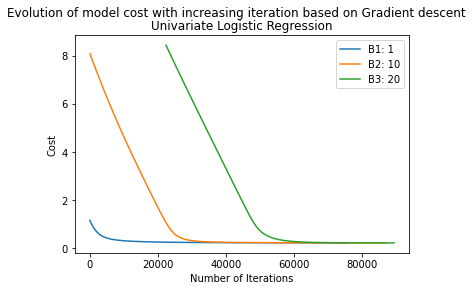

In [ ]:
#plot the evolution of the cost at each iteration
initial_vals = ['B1: 1', 'B2: 10', 'B3: 20']
for i in range(3):
  plt.plot(range(len(cost_simple[i])),cost_simple[i])
  plt.xlabel('Number of Iterations')
  plt.ylabel('Cost')
  plt.legend(labels = initial_vals)
  plt.suptitle('Evolution of model cost with increasing iteration based on Gradient descent')
  plt.title("Univariate Logistic Regression")


#### Multiple Logistic Regression

In [ ]:
# Experimenting with different parameter initialization values
# Multiple Logistic Regression
beta_shape = Xm.shape[1]

initials = [1, 10, 20] # values to adjust initialization parameters
alpha = 0.001
iter = 100000
cost_multiple = []

for e in initials:
  beta = e*np.ones(beta_shape, ).reshape(Xm.shape[1], 1)
  beta_val_multiple, cost_val_multiple= grad_descent(Xm, Y, beta, alpha, iter)
  cost_multiple.append(cost_val_multiple)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in multiply
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars


In [ ]:
# The optimal parameter values for developing our simple logistic regression
optimum_value=beta_val_multiple[len(cost_multiple)-1]
print("The optimal parameters value for developing our multiple logistic regression are: \n", optimum_value)

The optimal parameters value for developing our multiple logistic regression are: 
 [20.0005949  19.99781053 19.99777797 19.99790047 19.99775338 19.99771734
 19.99769884 19.99786952 19.99770056]


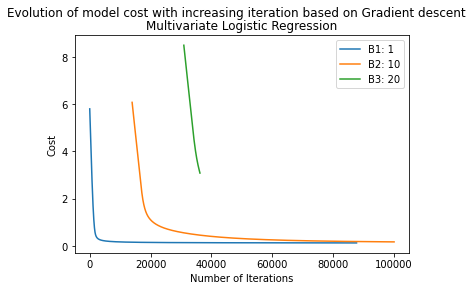

In [ ]:
initial_vals = ['B1: 1', 'B2: 10', 'B3: 20']
for i in range(3):
  plt.plot(range(len(cost_multiple[i])),cost_multiple[i])
  plt.xlabel('Number of Iterations')
  plt.ylabel('Cost')
  plt.legend(labels = initial_vals)
  plt.suptitle('Evolution of model cost with increasing iteration based on Gradient descent')
  plt.title("Multivariate Logistic Regression")

COMMENTS:

In the two cases shown above, we see the evolution of our model cost at each iteration for different initialisation values for both the multivariate logistic regression and the univariate regression. For both the univariate and multivariate logistic regression, the smaller the initial value, the closer it is to the global minimum and lesser number iterations needed to reach cost convergence and extract the optimal parameter value. Although, a possible case of converging before reaching the global minimum was seen in the multivariate logistic regression, with an initialisation value of 20. This could potentially be caused by the error tolerance encoded in the optimisation algorithm or the learning rate.



## Test Gradient Descent with different learning rate
Experiment with several learning rate: visualisation of the cost function and parameter values during the iterations

#### Simple Logistic Regression
We evaluated the evolution of our cost with different learning rates based on the gradient descent algorithm

In [ ]:
# Modify simple logistic regression learning rate
learning_rate = (0.0001, 0.005, 0.01)
cost_lr = []
vector_size=Xs.shape[1]
beta = np.ones(vector_size, ).reshape(Xs.shape[1], 1)

for lr in learning_rate:
  beta_val, cost_val= grad_descent(Xs, Y, beta,lr, iter)
  cost_lr.append(cost_val)

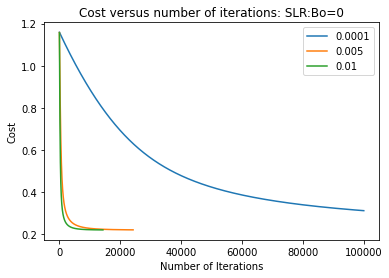

In [ ]:
# Visualization of cost evolution at different learning rates

for i in range(3):
  plt.plot(range(len(cost_lr[i])),cost_lr[i])
  plt.xlabel('Number of Iterations')
  plt.ylabel('Cost')
  plt.legend(labels = learning_rate)
  plt.title('Cost versus number of iterations: SLR:Bo=0')

#### Multiple Logistic Regression

In [ ]:
# Adjust multiple logistic regression learning rate
learning_rate = (0.00005, 0.0001, 0.005, 0.01)
cost_lr_m = []

vector_size=Xm.shape[1]
beta = np.ones(beta_shape, ).reshape(Xm.shape[1], 1)

for lr in learning_rate:
  beta_val, cost_val_m= grad_descent(Xm, Y, beta, lr, iter)
  cost_lr_m.append(cost_val_m)

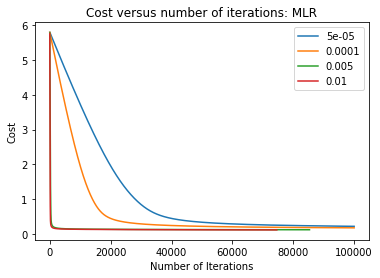

In [ ]:
no =[0, 1, 2, 3]

for i in range(4):
  plt.plot(range(len(cost_lr_m[i])),cost_lr_m[i])
  plt.xlabel('Number of Iterations')
  plt.ylabel('Cost')
  plt.legend(labels = learning_rate)
  plt.title('Cost versus number of iterations: MLR')

COMMENTS:

In the two models above, the learning rates were adjusted to capture the different behaviours of our logistic model by its corresponding cost at each iteration. The lower the learning rate, the more iterations is required for the optimisation algorithm to converge and extract the optimal parameters of the algorithms. A higher learning rate risks skipping the global minima or converging before reaching it. Generally, the smaller the learning rate, the more iterations would be needed to capture the optimal parameters. 

## Gradient Descent Estimation versus other Optimization Algorithms
Compare the Gradient Descent Computation with native Python Optimization solutions

In [ ]:
# Optimizing the cost function using the
"""
beta = np.ones(shape=(Xs.shape[1], 1))
from scipy.optimize import minimize, fmin_tnc
def test_fit(x, y, beta):
  optimal_beta = fmin_tnc(cost(x, y, beta), x0=beta, fprime=grad(x, y, beta))
  return optimal_beta[0]
  
native_param = test_fit(Xs, Y, beta)
"""
from scipy.optimize import minimize

def native_optimizer(x, cost):
  vector_size = x.shape[1]
  beta = np.ones(vector_size, ).reshape(x.shape[1], 1)

  res = minimize(
      cost,
      x0=beta,
      args= (x, beta)
      )
  optimal_param = res.x

  return optimal_param

opt_param_native_simple = native_optimizer(Xs, cost)
opt_param_native_multiple = native_optimizer(Xm, cost)

In [ ]:
print('Optimal parameters based on native python optimisation algorithm: ', opt_param_native_simple)

Optimal parameters based on native python optimisation algorithm:  [-3.12589092e-10 -3.12593309e-10]


In [ ]:
print('Optimal parameters based on native python optimisation algorithm: ', opt_param_native_multiple)

Optimal parameters based on native python optimisation algorithm:  [-0.23104907 -0.23104907 -0.23104907 -0.23104907 -0.23104907 -0.23104907
 -0.23104907 -0.23104907 -0.23104907]


In [ ]:
y_pred_native = probability(Xs, opt_param_native_simple)
score_native = float(sum(np.rint(y_pred) == Y[:, 0]))/ float(len(Y))
print("Accuracy of native optimisation algorithm", score_native)

Accuracy of native optimisation algorithm 0.9173989455184535


In [ ]:
print('Accuracy of Gradient Descent Algorithm: ', score)

Accuracy of Gradient Descent Algorithm:  0.9420035149384886


COMMENTS:

Here, we compare the performance of our hand-crafted gradient descent algorithm with a native function optimisation algorithm in Python. Here, we optimise the cost function and used the optimal parameter to predict the classes of our targets. Comparatively, our Gradient Descent Algorithm performed better than the native optimisation algorithm but at a very a minute scale. 

# **Regularisation**


In this section of the notebook, the sets of regularisation techniques for linear model were evaluated for their relative performances and sensitivity to specific hyperparameters. 
The first part modified the gradient descent algorithm to contain a ridge penalizer to obtain the optimal model parameters by forcing the parameters to take smalller values. In the second part, the relative performance of these regularizers was compared as well as the influence of the regularizer on a model prediction.

### Utilities

In [ ]:
# utilities
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.metrics import accuracy_score
from sklearn.metrics import PrecisionRecallDisplay

In [ ]:
# split data into train and test sets

# simple logistic regression
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, Y, test_size = 0.30, random_state=0)


# multiple logistic regression
Xm_train, Xm_test, ym_train, ym_test = train_test_split(Xm, Y, test_size = 0.30, random_state=0)

### Ridge regression

In [ ]:
#-- Ridge Regularized Cost function and Gradient Descent Algorithm

'''
The Logistic regression cost is estimated by the Log-likelihood function. 
The aim of our modelling is to maximise the Log-likelihood at each iteration to 
get the best weight for our model
'''

def reg_cost(x, y, beta, penalty):
  m = x.shape[0]
  f = probability(x, beta)
  ridge_regularizer = (penalty/2*m)*np.sum(np.square(beta))
  return -((1/m)* np.sum(y*np.log(f) + (1-y)*np.log(1-f))) + ridge_regularizer


def reg_grad_descent(x, y, beta, alpha, penalty, no_of_iter, tolerance = 0.0000001):
    #size of observations, m
    m = x.shape[0]
    
    # d
    size = x.shape[1]

    #list to store the beta values and cost values
    parameters = np.zeros([no_of_iter, size])

    costs_val=[]
    
    #calculate the beta values for each iteration

    for i in range(no_of_iter):
      beta = beta*(1 - (penalty*alpha/m)) - alpha*grad(x, y, beta)

      parameters[i, :]=beta.reshape(size)

      costs= reg_cost(x, y, beta, penalty)
      
      if len(costs_val)>=2 and costs_val[-1]-costs<tolerance:
        break
      costs_val.append(costs)

    return parameters, costs_val


Text(0.5, 1.0, 'Cost vs Iterations Analysis::Simple Logistic Regression')

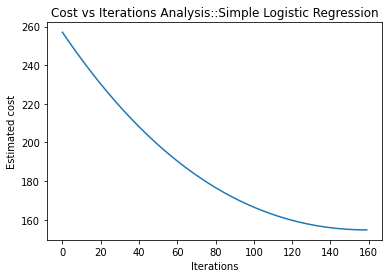

In [ ]:
# Test for simple Logistic Regression

beta = np.random.rand(Xs.shape[1]).reshape(Xs.shape[1], 1)
alpha = 0.01   #Learning Rate
no_iter = 10000  #number of iteration tested on

#beta = np.random.randn(beta_shape, 1) #initializing random values

parameters, cost_values = reg_grad_descent(Xs, Y, beta, alpha, 0.8, no_iter, 0.0001)

optimal_params=parameters[len(cost_values)-1]

# Plotting Line Plot for Number of Iterations vs MSE
plt.plot(range(len(cost_values)),cost_values)
plt.xlabel('Iterations')
plt.ylabel('Estimated cost')
plt.title('Cost vs Iterations Analysis::Simple Logistic Regression')


In [ ]:
optimal_params

array([ 0.80917322, -0.1490289 ])

In [ ]:
pred = probability(Xs, optimal_params)
accuracy_sc = float(sum(np.rint(pred) == Y[:, 0]))/ float(len(Y))
print("Accuracy of Ridge Regularized Model", accuracy_sc)

Accuracy of Ridge Regularized Model 0.6274165202108963


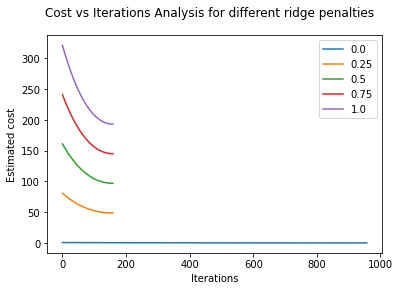

In [ ]:
# Sensitivity of the ridge regression to the hyperparameter (called penalty in this code)
penalties = np.linspace(0, 1, 5)
for pen in penalties:
  parameters, cost_values = reg_grad_descent(Xs, Y, beta, alpha, pen, no_iter, 0.0001)
  optimal_params=parameters[len(cost_values)-1]
  # Plotting Line Plot for Number of Iterations vs MSE
  plt.plot(range(len(cost_values)),cost_values)
  plt.xlabel('Iterations')
  plt.ylabel('Estimated cost')
  plt.suptitle('Cost vs Iterations Analysis for different ridge penalties')
  plt.legend(np.linspace(0, 1, 5))



**COMMENT**
In the two cases, above we see an effect of the ridge penalizer on simplifying our logistic model. In the first case, where we are given a regularized gradient descent, the optimization algorithm converged faster and selected smaller model parameters. 

In the case above, we drop in overall model performance to about 63%. This shows that while regularization may not improve model performance, it increases the ability of the model to generalize to new unseen datasets. Since, this is the goal of machine learning projects, we include the regularization terms in our model to reduce the complexity and over-dependent of our model on the input data (also referred to as overfitting).

In the second case, we see the influence of penalty term on capturing the reducing the model cost following the path of our optimisation algorithm: Gradient Descent. In the case of the ridge regression, we see that increasing the penalty value signifying the regularization strength, increases the optimal cost of reaching the global minimum. 


### Comparison of regularization techniques

Use Python methods to compare the results of three regularization techniques: ridge regression, LASSO and ElasticNet.


#### Comparison of Ridge, Lasso and ElasticNet

In [ ]:
# Compare the relative performance of the three regularization techniques 
# for Logistic Linear Regression

def regularizer(x_train, y_train, x_test, y_test):
  """
  A function to compare the performance of different linear model regularizers
  Parameters: x_train, y_train, x_test, y_test
  Output: Accuracies and Predicted Values of Ridge, Lasso, and ElasticNet 
  Regression. 
  """

  ridge = Ridge(random_state=0)
  lasso = Lasso(random_state= 0)
  elasticnet =ElasticNet(random_state=0)
  
  estimators = (ridge, lasso, elasticnet)
  parameters = {'alpha': (0.2, 0.4, 0.6, 0.8, 1.0)}
  
  acc = []
  predictions = []

  for est in estimators:
    clf = est
    clf.fit(x_train, y_train)
    y_pred = np.rint(clf.predict(x_test))

    predictions.append(y_pred)
    acc.append(accuracy_score(y_test, y_pred))

  return acc, predictions

In [ ]:
accuracies, y_predictions = regularizer(Xs_train, ys_train, Xs_test, ys_test)

In [ ]:
# Ridge, Lasso, and ElasticNet
accuracies

[0.8888888888888888, 0.631578947368421, 0.631578947368421]

In this case, the ridge regressor has the highest performance on new unseen data (test data). Both Lasso and ElasticNet have similar model accuracy on the new data. Although, the ElasticNet regularizer, has been considered to be a more robust option for reducing model complexity and improving its generalization, in certain cases, one of lasso or ridge regression captures the true data distribution we would love to model. 

#### Tune the lambda hyperparameter value by using a cross-validation procedure.

Compare the performance of each algorithm with the optimal hyperparameter.

In [ ]:
def optimal_hyperparameter(x_train, y_train, x_test, y_test):
  
  """
  A function that searches for the optimal penalty value (between 0 and 1) for 
  different linear model regularizers using the Grid Search Cross-Validation 
  technique. Afterwards, the model with the best parameter is used to predict 
  the test data. 
  """

  ridge = Ridge(random_state=0)
  lasso = Lasso(random_state= 0)
  elasticnet =ElasticNet(random_state=0)
  estimators = [ridge, lasso, elasticnet]

  parameters = {'alpha': np.linspace(0, 1, 10)}
  optimal_models = []
  optimized_accuracies = []
  optimized_predictions = []

  for est in estimators: 
    clf = GridSearchCV(est, 
                   parameters,
                   refit = True, 
                   cv = 5, 
                   error_score = 0
                   )
    clf.fit(x_train, y_train)

    optimal_clf = clf.best_estimator_
    optimal_models.append(optimal_clf)

    optimized_y = np.rint(optimal_clf.predict(x_test))
    optimized_predictions.append(optimized_y)

    optimized_accuracy = accuracy_score(y_test, optimized_y)
    optimized_accuracies.append(optimized_accuracy)

  return optimal_models, optimized_accuracies, optimized_predictions

In [ ]:
reg_model_parameters, reg_models_accuracies, reg_predictions = optimal_hyperparameter(Xs_train,
                       ys_train,
                       Xs_test,
                       ys_test
                       )

In [ ]:
reg_model_parameters_mult, reg_models_accuracies_mult, reg_predictions_mult = optimal_hyperparameter(Xm_train,
                                                                                      ym_train,
                                                                                      Xm_test,
                                                                                      ym_test
                                                                                      )

In [ ]:
print(" Regularized Model Parameters for univariate model: \n ", reg_model_parameters)
print('\n')
print(" Regularized Model Parameters for multiivariate model: \n  ", reg_model_parameters_mult)

 Regularized Model Parameters for univariate model: 
  [Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=0, solver='auto', tol=0.001), Lasso(alpha=0.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=0,
      selection='cyclic', tol=0.0001, warm_start=False), ElasticNet(alpha=0.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=0, selection='cyclic', tol=0.0001, warm_start=False)]


 Regularized Model Parameters for multiivariate model: 
   [Ridge(alpha=0.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=0, solver='auto', tol=0.001), Lasso(alpha=0.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=0,
      selection='cyclic', tol=0.0001, warm_start=False), Elasti

For the best penalty values for the Univariate model,

- Ridge = 1, 
- Lasso = 0, and 
- ElasticNet = O

To reach the optimal parameter of model complexity. 

For the Multivariate model, 
- Ridge = 0
- Lasso = 0
- ElasticNet = 0


The question to ask is, how does this influence model performance. 

In [ ]:
print("Respective model accuracy for Ridge, Lasso and ElasticNet: Univariate ", reg_models_accuracies)
print('\n')
print("Respective model accuracy for Ridge, Lasso and ElasticNet: Multivariate ", reg_models_accuracies_mult)


Respective model accuracy for Ridge, Lasso and ElasticNet: Univariate  [0.8888888888888888, 0.8888888888888888, 0.8888888888888888]


Respective model accuracy for Ridge, Lasso and ElasticNet: Multivariate  [0.9415204678362573, 0.9415204678362573, 0.9415204678362573]


As seen above, the three models have similar performance since the relatively best penalty term were used for each of them.

#### Evaluate the performance of the linear regression algorithm on test data with and without regularization. 

In [ ]:
# Logistic Regression without Regularization
clf = LogisticRegression(
      random_state=0,
      max_iter=5000,
      tol=0.0000001
      )
clf.fit(Xm_train, ym_train)

y_pred = clf.predict(Xm_test)

lasso_acc = accuracy_score(ym_test, y_pred)
lasso_acc

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9473684210526315

In [ ]:
# Logistic Regression with Regularization
clf = LogisticRegression(
      solver='liblinear', 
      random_state=0,
      l1_ratio = 0.5,
      penalty='l1',
      max_iter=5000,
      tol=0.0000001
      )

clf.fit(Xm_train, ym_train)
y_pred = clf.predict(Xm_test)
lasso_acc = accuracy_score(ym_test, y_pred)
lasso_acc

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty))
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9532163742690059

COMMENT

Here, we take a look at the overall performance of the logistic regression with and withour regularisation. When the model is regularised, the accuracy increases in our example on the test sets. This shows that the model with regularization improves its generalization capability. 
It should be noted, that the goal of regularization is not improve the accuracy over the training set but to improve its performance over new unseen data. 